In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ugoj5ywj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ugoj5ywj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
--2023-04-20 05:02:43--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## Example image

In [5]:
image = cv2.imread('/content/drive/MyDrive/segment any thing Meta /IMG_20230420_050307.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
image = cv2.imread('/content/drive/MyDrive/segment any thing Meta /IMG_20230420_050307.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

new_height, new_width = int(image.shape[0]/2), int(image.shape[1]/2)
image = cv2.resize(image, (new_width, new_height))
image

array([[[106, 108, 156],
        [107, 109, 157],
        [109, 110, 156],
        ...,
        [136, 137, 184],
        [135, 136, 183],
        [136, 138, 185]],

       [[107, 109, 156],
        [107, 110, 155],
        [108, 109, 155],
        ...,
        [137, 137, 192],
        [136, 136, 191],
        [136, 137, 192]],

       [[106, 109, 153],
        [107, 110, 153],
        [108, 109, 153],
        ...,
        [136, 135, 195],
        [136, 135, 195],
        [136, 136, 196]],

       ...,

       [[ 17,  21,  24],
        [ 16,  20,  23],
        [ 18,  22,  25],
        ...,
        [ 34,  34,  42],
        [ 34,  34,  42],
        [ 33,  33,  41]],

       [[ 16,  20,  23],
        [ 14,  18,  21],
        [ 16,  20,  23],
        ...,
        [ 33,  33,  41],
        [ 33,  33,  41],
        [ 30,  30,  38]],

       [[ 17,  21,  24],
        [ 15,  19,  22],
        [ 15,  19,  22],
        ...,
        [ 32,  32,  40],
        [ 32,  32,  40],
        [ 30,  30,  38]]

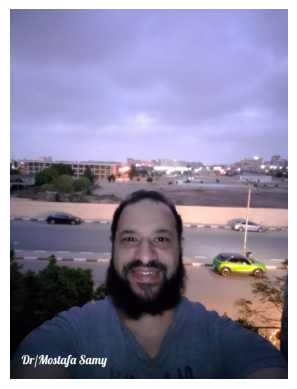

In [9]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Load the image
image_path = '/content/drive/MyDrive/segment any thing Meta /IMG_20230420_050307.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the patch size
patch_size = 512

# Create a list to store the masks for each patch
patch_masks = []

# Loop over the image patches
for i in range(0, image.shape[0], patch_size):
    for j in range(0, image.shape[1], patch_size):
        # Get the patch
        patch = image[i:i+patch_size, j:j+patch_size]

        # Generate the mask for the patch
        sam_checkpoint = "sam_vit_h_4b8939.pth"
        model_type = "vit_h"

        device = "cuda"

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        mask_generator = SamAutomaticMaskGenerator(sam)
        patch_mask = mask_generator.generate(patch)

        # Store the mask for the patch
        patch_masks.append(patch_mask)



In [16]:
# Combine the patch masks to obtain the final mask for the entire image
mask = np.zeros((image.shape[0], image.shape[1]))
for i in range(0, image.shape[0], patch_size):
    for j in range(0, image.shape[1], patch_size):
        k = int(i/patch_size*(image.shape[1]/patch_size) + j/patch_size)
        patch_mask = np.array(patch_masks[k])
        if patch_mask.size != patch_size**2:
            continue
        patch_mask = patch_mask.reshape((patch_size, patch_size))
        mask[i:i+patch_size, j:j+patch_size] = patch_mask



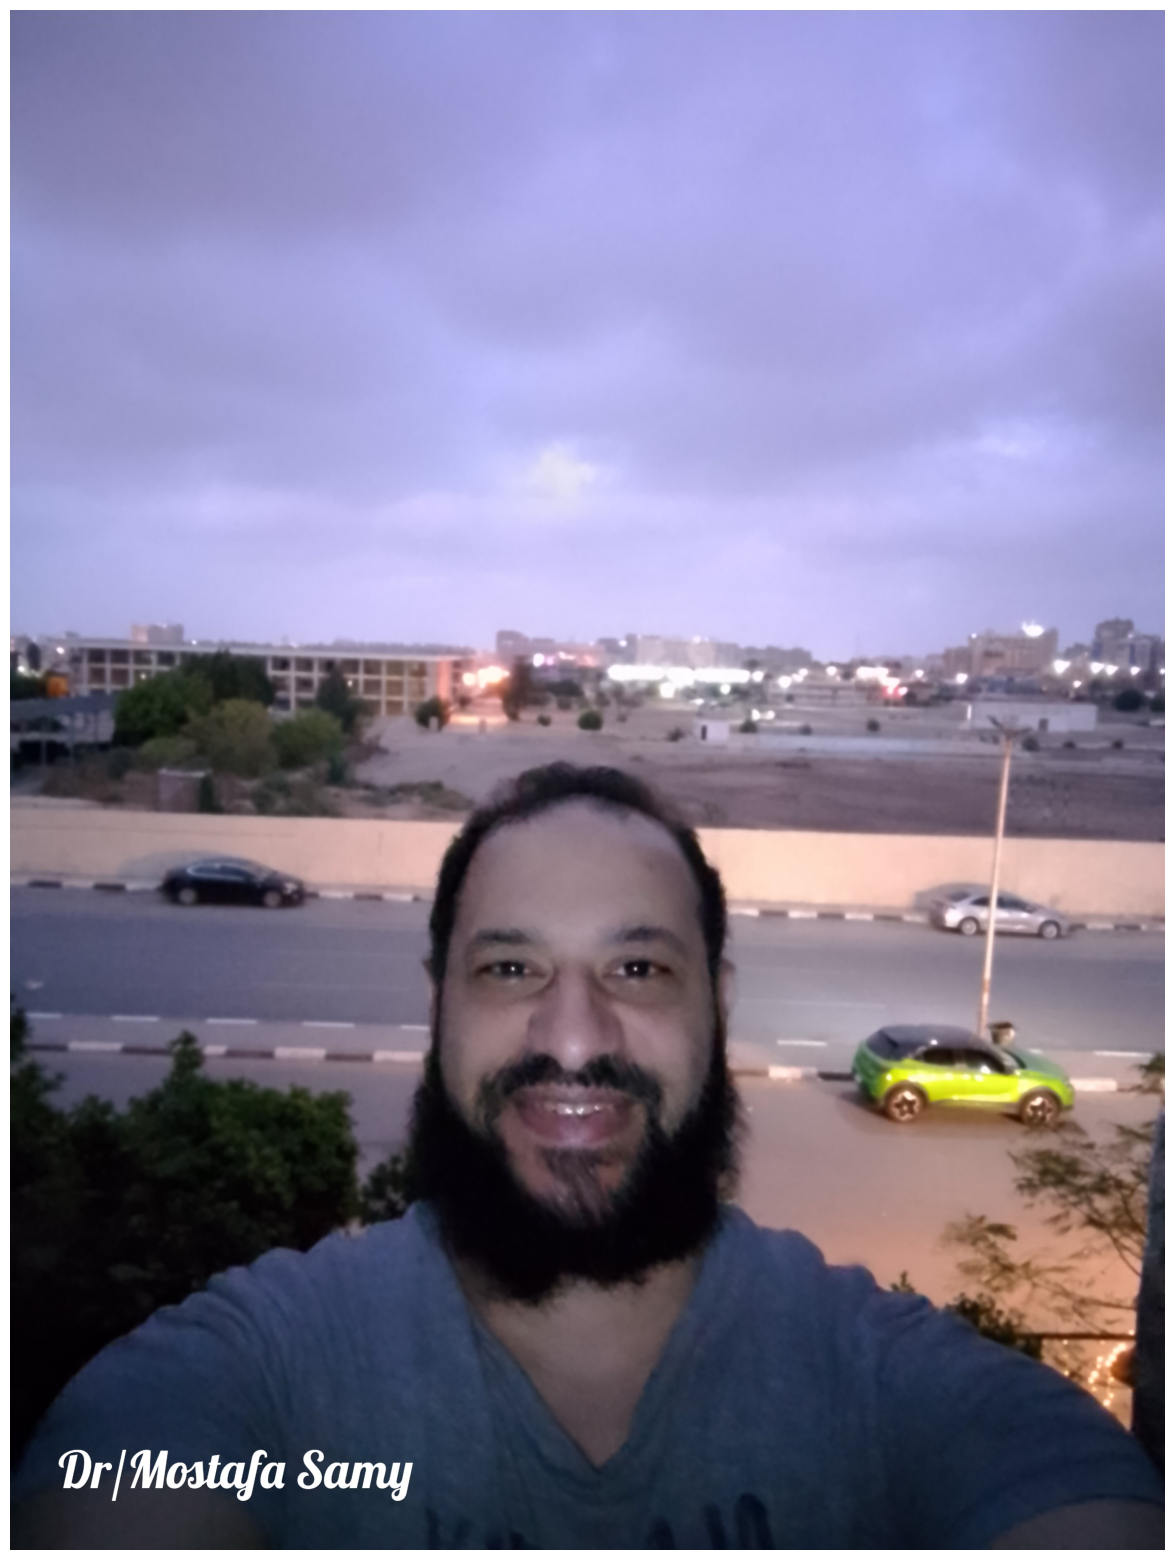

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [11]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [12]:
print(len(masks))
print(masks[0].keys())

94
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

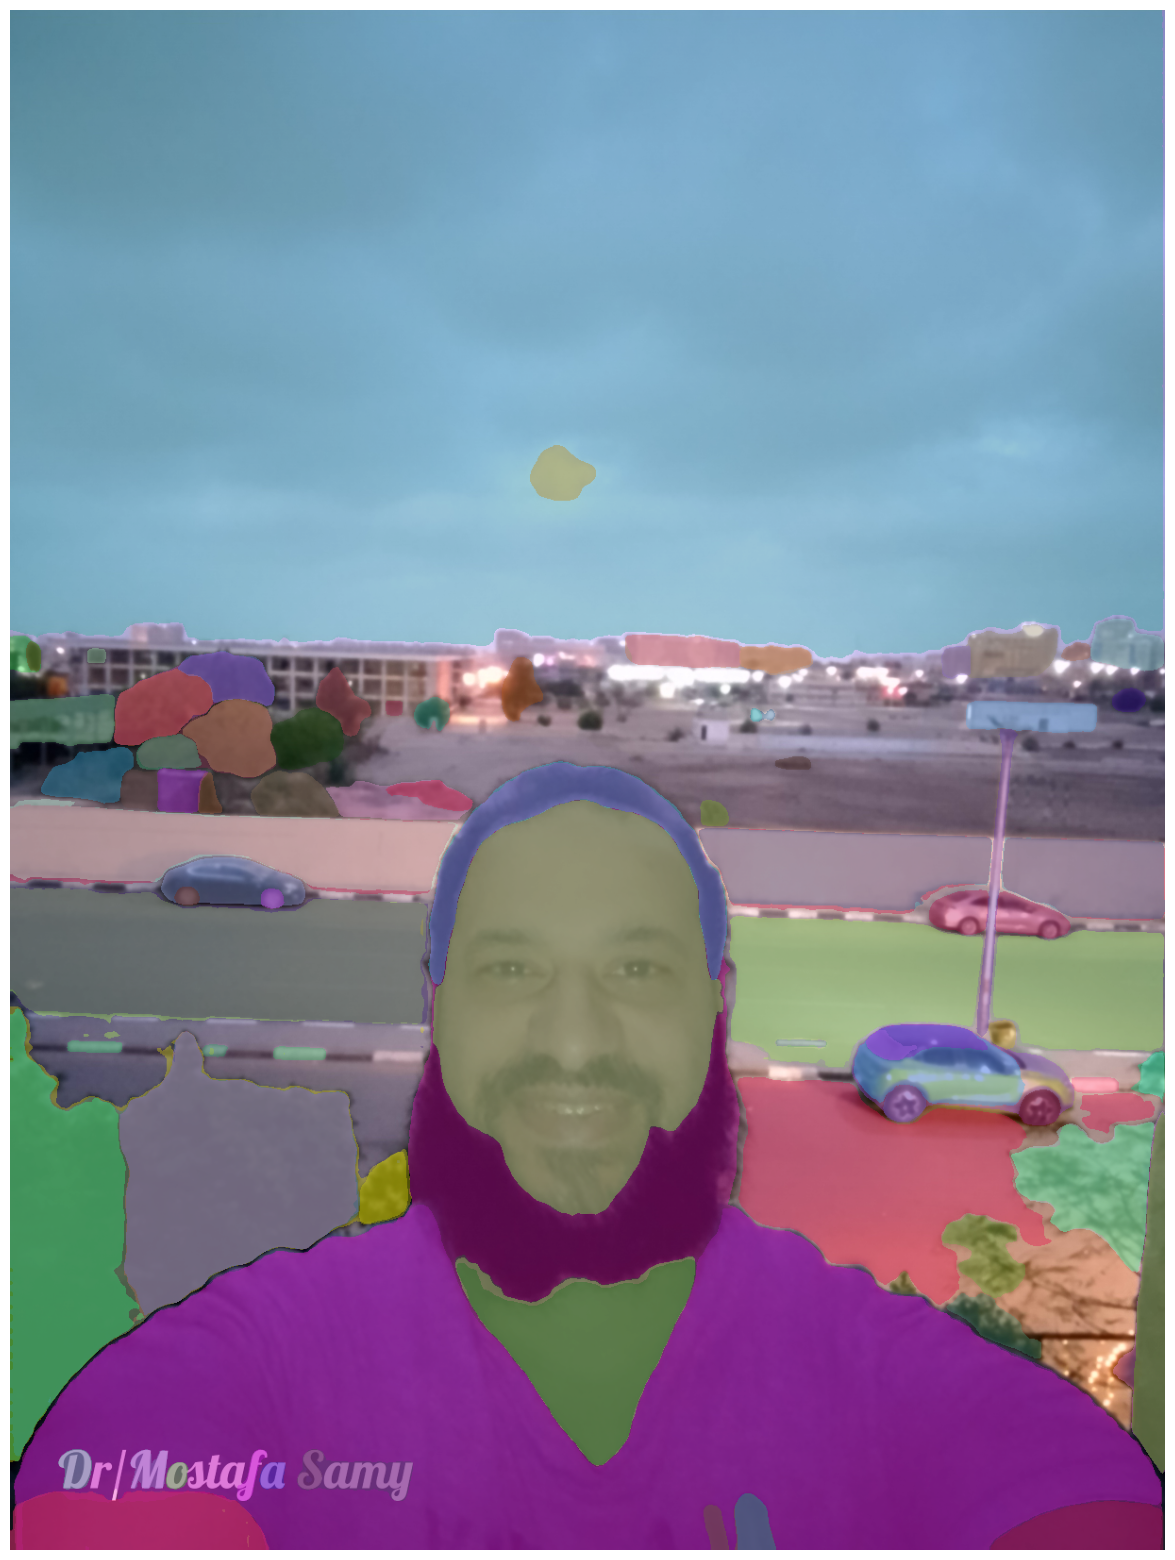

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
!pip install opencv

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [1]:
!nvidia-smi

Thu Apr 20 04:48:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aeply2g7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aeply2g7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=91a115658c780e3db5b2e3acc5afb5e9be15b9a84a81bc05be08fd31d50ab964
  Stored in directory: /tmp/pip-ephem-wheel-cache-62h8ph2a/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00


In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [8]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [9]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
import os

IMAGE_NAME = "/content/drive/MyDrive/segment any thing Meta /IMG_20230420_050307.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [18]:
!pip install pynvml 
!pip install nvmlInit 
!pip install nvmlDeviceGetHandleByIndex 
!pip install nvmlDeviceGetMemoryInfo
import torch
import time
import gc
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()
    del variables

def wait_until_enough_gpu_memory(min_memory_available, max_retries=10, sleep_time=5):
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(torch.cuda.current_device())

    for _ in range(max_retries):
        info = nvmlDeviceGetMemoryInfo(handle)
        if info.free >= min_memory_available:
            break
        print(f"Waiting for {min_memory_available} bytes of free GPU memory. Retrying in {sleep_time} seconds...")
        time.sleep(sleep_time)
    else:
        raise RuntimeError(f"Failed to acquire {min_memory_available} bytes of free GPU memory after {max_retries} retries.")

# Usage example
min_memory_available = 2 * 1024 * 1024 * 1024  # 2GB
clear_gpu_memory()
wait_until_enough_gpu_memory(min_memory_available)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pynvml-11.5.0-py3-none-any.whl (53 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nvmlInit (from versions: none)
ERROR: No matching distribution found for nvmlInit
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nvmlDeviceGetHandleByIndex (from versions: none)
ERROR: No matching distribution found for nvmlDeviceGetHandleByIndex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nvmlDeviceGetMemoryInfo (from versions: none)
ERROR: No matching distribution found for nvmlDeviceGetMemoryInfo


UnboundLocalError: ignored

In [15]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

OutOfMemoryError: ignored

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)